In [34]:
"""

PROD ALERT 2 CODE

Copyright © 2023 Dr Keith S Reid Cailleach Computing Ltd

keithreid@nhs.net

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated 
documentation files (the “Software”), to deal in the Software without restriction, including without limitation 
the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and 
to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions 
of the Software.

THE SOFTWARE IS PROVIDED “AS IS”, WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED 
TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL 
THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF 
CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER 
DEALINGS IN THE SOFTWARE.

""";

#       LIBRARIES

import math
import matplotlib.gridspec                as gridspec
import matplotlib.pylab                   as pl
import matplotlib.pyplot                  as plt
import numpy                              as np
from   numpy.polynomial import polynomial as P
import pandas                             as pd
import warnings

from scipy.stats import norm

#       CONFIGURE SETTINGS

warnings.filterwarnings('ignore')                                
pd.options.display.max_rows     = None
pd.options.display.max_columns  = None
plt.rcParams["figure.figsize"] = (16,8)

def get_five_or_nothing():
    # this partial provider is excluded from both funnel plots
    # due to only reporting 5 or 0
    # the effect is to spuriously have very low variance
    return [0.0,               2.584962500721156, 2.584962500721156, 
            2.584962500721156, 2.584962500721156, 2.584962500721156, 
            2.584962500721156, 2.584962500721156, 0.0, 
            2.584962500721156, 0.0,               2.584962500721156]

def get_twothirty_or_nothing():
    # this partial provider is excluded from both funnel plots
    # due to only reporting 230 or 0 75% of the time
    # the effect is to spuriously have very low variance
    return [0.0,               0.0,               0.0, 
            0.0,               0.0,               7.851749041416057, 
            7.851749041416057, 7.851749041416057, 7.6865005271832185, 
            0.0,               0.0,               7.539158811108031]
    
def get_reported_twice_too():
    # excluded from detention funnel plot
    return [3.4594316186372973, 0.0, 0.0, 
            0.0,                0.0, 0.0, 
            0.0,                0.0, 0.0, 
            3.4594316186372973, 0.0, 0.0]
    
def get_reported_restraint_twice():
    # excluded from detention funnel plot
    # it gave them huge precision of 9679688.492560597
    return [0.0,               0.0,               0.0, 
            0.0,               0.0,               0.0, 
            0.0,               0.0,               2.584962500721156, 
            0.0,               2.584962500721156, 0.0]

def get_small_for_rstr():
    # these are small enough to have 0 arise by chance
    # smallness is handled as a configuration because it is based on a judgement
    get_small_for_rstr = ["SCHOEN CLINIC YORK",
                        "GREAT ORMOND STREET HOSPITAL FOR CHILDREN NHS FOUNDATION TRUST",
                        "ALDER HEY CHILDREN'S NHS FOUNDATION TRUST",
                        "TURNING POINT",
                        "NEWMARKET HOUSE HEALTHCARE LTD",
                        "WHITTINGTON HEALTH NHS TRUST",
                        "MANCHESTER UNIVERSITY NHS FOUNDATION TRUST",
                        "NORTHUMBRIA HEALTHCARE NHS FOUNDATION TRUST",
                        "NEWBRIDGE CARE SYSTEMS LTD",
                        "BRAMLEY HEALTH",
                        "REGIS HEALTHCARE LIMITED"]
    return get_small_for_rstr

def get_small_for_sect():
    # these are small enough to have 0 arise by chance
    # smallness is handled as a configuration because it is based on a judgement
    small_for_sect = ["SCHOEN CLINIC YORK",
                        "GREAT ORMOND STREET HOSPITAL FOR CHILDREN NHS FOUNDATION TRUST",
                        "ALDER HEY CHILDREN'S NHS FOUNDATION TRUST",
                        "TURNING POINT",
                        "NEWMARKET HOUSE HEALTHCARE LTD",
                        "WHITTINGTON HEALTH NHS TRUST",
                        "MANCHESTER UNIVERSITY NHS FOUNDATION TRUST",
                        "NORTHUMBRIA HEALTHCARE NHS FOUNDATION TRUST",
                        "NEWBRIDGE CARE SYSTEMS LTD",
                        "BRAMLEY HEALTH",
                        "REGIS HEALTHCARE LIMITED",
                        "RIVERDALE GRANGE LIMITED",
                        "SHEFFIELD CHILDREN'S NHS FOUNDATION TRUST",
                        "EQUILIBRIUM HEALTHCARE",
                        "BIRMINGHAM WOMEN'S AND CHILDREN'S NHS FOUNDATION TRUST",
                        "DERBYSHIRE COMMUNITY HEALTH SERVICES NHS FOUNDATION TRUST",
                        "ACTIVE PATHWAYS",
                        "NEWBRIDGE CARE SYSTEMS",
                        "MAKING SPACE",
                        "ELLERN MEDE BARNET",
                        "CARETECH COMMUNITY SERVICES (NO.2) LIMITED"]
    return small_for_sect

def get_verbose():
    verbose = "No" # "Yes" or "No"
    return verbose

#       GET DATA

def get_beds_files():
    beds_files = ["beds01_Sep_2021.csv", "beds02_Oct_2021.csv", "beds03_Nov_2021.csv",
                  "beds04_Dec_2021.csv", "beds05_Jan_2022.csv", "beds06_Feb_2022.csv",
                  "beds07_Mar_2022.csv", "beds08_Apr_2022.csv", "beds09_May_2022.csv",
                  "beds10_Jun_2022.csv", "beds11_Jul_2022.csv", "beds12_Aug_2022.csv"]
    return beds_files

def get_providers():
    beds_files              = get_beds_files()
    names_with_some_beds    = []
    for this_file in beds_files:
        df          = pd.read_csv(this_file, header=None)
        df.columns  = ["Month","Provider","Metric","Count"]
        for index, row in df.iterrows():
            if row["Count"] != "*":
                names_with_some_beds.append(row["Provider"])
    providers   = sorted(list(set(names_with_some_beds)))
    return providers

def get_rstr_files():
    rstr_files = ["rstr01_Sep_2021.csv", "rstr02_Oct_2021.csv", "rstr03_Nov_2021.csv",
                  "rstr04_Dec_2021.csv", "rstr05_Jan_2022.csv", "rstr06_Feb_2022.csv",
                  "rstr07_Mar_2022.csv", "rstr08_Apr_2022.csv", "rstr09_May_2022.csv",
                  "rstr10_Jun_2022.csv", "rstr11_Jul_2022.csv", "rstr12_Aug_2022.csv"]
    return rstr_files

def get_sect_files():
    rstr_files = ["sect01_Sep_2021.csv", "sect02_Oct_2021.csv", "sect03_Nov_2021.csv",
                  "sect04_Dec_2021.csv", "sect05_Jan_2022.csv", "sect06_Feb_2022.csv",
                  "sect07_Mar_2022.csv", "sect08_Apr_2022.csv", "sect09_May_2022.csv",
                  "sect10_Jun_2022.csv", "sect11_Jul_2022.csv", "sect12_Aug_2022.csv"]
    return rstr_files

#       BUILD TABLES

def analyse_provider_residuals(log_main):
    classified_providers                = classify_providers(log_main)
    best_c, best_m, complete_corr       = count_cm(classified_providers)
    each_predicted_restraint            = (classified_providers["LogBeds"]*best_m)+best_c
    each_residual                       = classified_providers["LogRstr"] - each_predicted_restraint
    classified_providers["Predicted"]   = each_predicted_restraint
    classified_providers["Residual"]    = each_residual
    return classified_providers, best_c, complete_corr

def sect_analyse_provider_residuals(log_main):
    sect_classified_providers           = sect_classify_providers(log_main)
    sect_c, sect_m, sect_corr           = sect_count_cm(sect_classified_providers) # sect corr not used; here for tidy tuple unpacking
    each_predicted_restraint            = (sect_classified_providers["LogSect"]*sect_m)+sect_c
    each_residual                       = sect_classified_providers["LogRstr"] - each_predicted_restraint
    sect_classified_providers["Predicted"]   = each_predicted_restraint
    sect_classified_providers["Residual"]    = each_residual
    return sect_classified_providers, sect_c, sect_corr

def build_log_main():
    # read the underlying csvs and associate those numbers with attributes
    providers               = get_providers()
    monthly_providers_beds  = build_monthly_providers_beds(providers)
    monthly_providers_rstr  = build_monthly_providers_rstr(providers)
    monthly_providers_sect  = build_monthly_providers_sect(providers)
                             
    # put them together in order and log transform to handle scale
    ordered_providers   = order_providers_by_size(monthly_providers_beds)
    ordered_beds        = pd.concat([ordered_providers,monthly_providers_beds], axis=1).reindex(ordered_providers.index)
    and_sect            = pd.concat([ordered_beds,monthly_providers_sect], axis=1).reindex(ordered_beds.index)
    and_rstr            = pd.concat([and_sect,monthly_providers_rstr], axis=1).reindex(and_sect.index)
    log_main            = laplace_correction_and_log(and_rstr)
    return log_main

def build_monthly_providers_beds(providers):
    beds_files              = get_beds_files()
    months                  = [x[0:10] for x in beds_files]
    monthly_providers_beds  = pd.DataFrame(columns = months, index = providers)
    for this_file in beds_files:
        month                       = this_file[0:10]
        monthly_bed_info            = pd.read_csv(this_file, header=None)
        monthly_bed_info.columns    = ["Month","Provider","Metric","Count"]
        for index, row in monthly_bed_info.iterrows():
            if row["Provider"] in providers:
                monthly_providers_beds.at[row["Provider"], month] = row["Count"]
                
    monthly_providers_beds.replace("*",   "0", inplace=True)
    monthly_providers_beds.fillna("0", inplace=True)
    return monthly_providers_beds

def build_monthly_providers_rstr(providers):
    rstr_files              = get_rstr_files()
    months                  = [x[0:10] for x in rstr_files]
    monthly_providers_rstr  = pd.DataFrame(columns = months, index = providers)
    for this_file in rstr_files:
        month                       = this_file[0:10]
        monthly_rstr_info            = pd.read_csv(this_file, header=None)
        monthly_rstr_info.columns    = ["Month","Provider","Metric","Count"]
        for index, row in monthly_rstr_info.iterrows():
            if row["Provider"] in providers:
                monthly_providers_rstr.at[row["Provider"], month] = row["Count"]
    monthly_providers_rstr.replace("*",   "0", inplace=True)
    monthly_providers_rstr.fillna("0", inplace=True)
    return monthly_providers_rstr

def build_monthly_providers_sect(providers):
    # kept this in the beds rstr version
    sect_files              = get_sect_files()
    months                  = [x[0:10] for x in sect_files]
    monthly_providers_sect  = pd.DataFrame(columns = months, index = providers)
    for this_file in sect_files:
        month                       = this_file[0:10]
        monthly_sect_info            = pd.read_csv(this_file, header=None)
        monthly_sect_info.columns    = ["Month","Provider","Metric","Count"]
        for index, row in monthly_sect_info.iterrows():
            if row["Provider"] in providers:
                monthly_providers_sect.at[row["Provider"], month] = row["Count"]
    monthly_providers_sect.replace("*",   "0", inplace=True)
    monthly_providers_sect.fillna("0", inplace=True)
    return monthly_providers_sect

#       MATHS MODEL

def count_bounds(classified_providers, best_c):
    complete_boolean            = [x in("FULL", "CLOSE") for x in classified_providers["Style"]]
    complete_rows               = classified_providers[complete_boolean]
    complete_residuals          = complete_rows["Residual"]
    complete_residuals_std_dev  = complete_residuals.std()
    complete_residuals_mean     = complete_residuals.mean()
    complete_LogRstr_minus_c    = complete_rows["LogRstr"] - best_c 
    complete_rows["Slopes"]     = complete_LogRstr_minus_c/complete_rows["LogBeds"]
    complete_slope_mean         = complete_rows["Slopes"].mean()
    complete_slope_std_dev      = complete_rows["Slopes"].std()
    slope_two_sigma             = 2 * complete_slope_std_dev
    lower_bound_slope           = complete_slope_mean -slope_two_sigma
    upper_bound_slope           = complete_slope_mean + slope_two_sigma
    classified_providers["Lower"] = best_c + (lower_bound_slope * 
                                              classified_providers["LogBeds"])
    classified_providers["Upper"] = best_c + (upper_bound_slope * 
                                              classified_providers["LogBeds"])
    distro_package              = complete_residuals,complete_residuals_mean,complete_residuals_std_dev
    return classified_providers, distro_package

def sect_count_bounds(sect_classified_providers, sect_c):
    complete_boolean            = [x in("FULL", "CLOSE") for x in sect_classified_providers["Style"]]
    complete_rows               = sect_classified_providers[complete_boolean]
    complete_residuals          = complete_rows["Residual"]
    complete_residuals_std_dev  = complete_residuals.std()
    complete_residuals_mean     = complete_residuals.mean()
    complete_LogRstr_minus_c    = complete_rows["LogRstr"] - best_c 
    complete_rows["Slopes"]     = complete_LogRstr_minus_c/complete_rows["LogSect"]
    complete_slope_mean         = complete_rows["Slopes"].mean()
    complete_slope_std_dev      = complete_rows["Slopes"].std()
    slope_two_sigma             = 2 * complete_slope_std_dev
    lower_bound_slope           = complete_slope_mean -slope_two_sigma
    upper_bound_slope           = complete_slope_mean + slope_two_sigma
    
    sect_classified_providers["Lower"] = best_c + (lower_bound_slope * 
                                              sect_classified_providers["LogSect"])
    sect_classified_providers["Upper"] = best_c + (upper_bound_slope * 
                                              sect_classified_providers["LogSect"])
    sect_distro_package          = complete_residuals,complete_residuals_mean,complete_residuals_std_dev
    return sect_classified_providers, sect_distro_package

def count_cm(df_beds_rstr):
    # derive m and c 
    # for y = mx+c
    boolean_complete_rows   = [x in("FULL","CLOSE") for x in df_beds_rstr["Style"]]
    complete_rows           = df_beds_rstr[boolean_complete_rows]
    best_c, best_m          = P.polyfit(complete_rows["LogBeds"],complete_rows["LogRstr"],1,full=False)
    complete_corr           = np.corrcoef(complete_rows["LogBeds"], complete_rows["LogRstr"])[0][1]
    return best_c, best_m, complete_corr

def sect_count_cm(df_sect_rstr):
    # derive m and c 
    # for y = mx+c
    # here the cleanest thing is to write a duplicate function with different internals
    # better than confusing non-coders with clever chain-of-responsibility flags
    boolean_complete_rows   = [x in("FULL","CLOSE") for x in df_sect_rstr["Style"]]
    complete_rows           = df_sect_rstr[boolean_complete_rows]
    boolean_not_NaN_rows    = [not np.isnan(x) for x in complete_rows["LogSect"]]
    complete_not_NaN        = complete_rows[boolean_not_NaN_rows] # a complete restraint report reports no detentions
    sect_c, sect_m          = P.polyfit(complete_not_NaN["LogSect"],complete_not_NaN["LogRstr"],1,full=False)
    sect_corr               = np.corrcoef(complete_rows["LogSect"], complete_rows["LogRstr"])[0][1]
    
    return sect_c, sect_m, sect_corr


def classify_providers(log_main):
        verbose = get_verbose()
        """
        This is the categorisation logic
        based on PROD-ALERT 1 published methods
        For PROD_ALERT-2
        Small?
            Yes -> "SMALL" ---------------> SMALL and (NO RESTRAINTS and (PARTIAL or JOINER bed-days))?
            No  -> Full?                        Yes -> "NULL"
                Yes -> "FULL"                   No  -> "SMALL"
                No  -> drops one?
                    Yes -> "CLOSE"
                    No  -> Joins?
                        Yes -> "JOINS"
                        No  -> "PARTIAL"
        """
        small_for_rstr  = get_small_for_rstr()
        names_beds_rstr = []
        for index, row in log_main.iterrows():
            reported_beds = [row["beds01_Sep"], row["beds02_Oct"], row["beds03_Nov"],
                             row["beds04_Dec"], row["beds05_Jan"], row["beds06_Feb"],
                             row["beds07_Mar"], row["beds08_Apr"], row["beds09_May"],
                             row["beds10_Jun"], row["beds11_Jul"], row["beds12_Aug"]]
            reported_rstr = [row["rstr01_Sep"], row["rstr02_Oct"], row["rstr03_Nov"],
                             row["rstr04_Dec"], row["rstr05_Jan"], row["rstr06_Feb"],
                             row["rstr07_Mar"], row["rstr08_Apr"], row["rstr09_May"],
                             row["rstr10_Jun"], row["rstr11_Jul"], row["rstr12_Aug"]]
            
            override_for_partial_joiner_beds = ["SCHOEN CLINIC YORK","TURNING POINT",
                                                "MANCHESTER UNIVERSITY NHS FOUNDATION TRUST",
                                                "NEWBRIDGE CARE SYSTEMS LTD","REGIS HEALTHCARE LIMITED",
                                                "ELLERN MEDE BARNET","CARETECH COMMUNITY SERVICES (NO.2) LIMITED",
                                                "JOHN MUNROE HOSPITAL","THE HUNTERCOMBE GROUP"]
            clean_beds      = [x for x in reported_beds if x>0]
            clean_rstr      = [x for x in reported_rstr if x>0]
            mean_beds       = np.mean(clean_beds)
            mean_rstr       = np.mean(clean_rstr)
                
            if index in small_for_rstr:
                if index in override_for_partial_joiner_beds:
                    mean_rstr       = 0.0
                    if verbose == "Yes":
                        beds_rstr_point = [index, "NULL", mean_beds, mean_rstr]
                    else:
                        beds_rstr_point = ["NULL", mean_beds, mean_rstr]
                else:
                    if math.isnan(mean_rstr):
                        mean_rstr       = 0.0
                        if verbose == "Yes":
                            beds_rstr_point = [index, "SMALL", mean_beds, mean_rstr]
                        else:
                            beds_rstr_point = ["SMALL", mean_beds, mean_rstr]
                names_beds_rstr.append(beds_rstr_point)
                
            else:
                if reported_rstr == [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]:
                    if index not in small_for_rstr:
                        mean_rstr       = 0.0
                        if verbose == "Yes":
                            beds_rstr_point = [index, "NULL", mean_beds, mean_rstr]
                        else:
                            beds_rstr_point = ["NULL", mean_beds, mean_rstr]
                        names_beds_rstr.append(beds_rstr_point)
                else:
                    if [x>0 for x in reported_rstr] == [True, True, True, True, True, True, True, True, True, True, True, True,]:
                        if verbose == "Yes":
                            beds_rstr_point = [index, "FULL", mean_beds, mean_rstr]
                        else:
                            beds_rstr_point = ["FULL", mean_beds, mean_rstr]
                        names_beds_rstr.append(beds_rstr_point)
                    else:
                        if sum([int(y) for y in [x>0 for x in reported_rstr]]) == 11:
                            if verbose == "Yes":
                                beds_rstr_point = [index, "CLOSE", mean_beds, mean_rstr]
                            else:
                                beds_rstr_point = ["CLOSE", mean_beds, mean_rstr]
                            names_beds_rstr.append(beds_rstr_point)
                        else:
                            if [[x>0 for x in reported_rstr][i-1]<=[x>0 for x in reported_rstr][i]
                                for i in list(range(1,12))] == [True, True, True, True, 
                                                                 True, True, True, True,
                                                                  True, True, True]:
                                if verbose == "Yes":
                                    beds_rstr_point = [index, "JOINS", mean_beds, mean_rstr]
                                else:
                                    beds_rstr_point = ["JOINS", mean_beds, mean_rstr]
                                names_beds_rstr.append(beds_rstr_point)
                            else:
                                if verbose == "Yes":
                                    beds_rstr_point = [index, "PARTIAL", mean_beds, mean_rstr]
                                else:
                                    beds_rstr_point = ["PARTIAL", mean_beds, mean_rstr]
                                names_beds_rstr.append(beds_rstr_point)
        classifed_providers         = pd.DataFrame(names_beds_rstr)
        if verbose == "Yes":
            classifed_providers.columns = ["Index","Style","LogBeds", "LogRstr"] 
        else:
            classifed_providers.columns = ["Style","LogBeds", "LogRstr"]
        return classifed_providers
    
def sect_classify_providers(log_main):
        # the detnetion version does not accept the verbose flag
        """
        This is the categorisation logic
        based on PROD-ALERT 1 published methods

        For PROD_ALERT-2
        Small?
            Yes -> "SMALL" ---------------> SMALL and (NO RESTRAINTS and (PARTIAL or JOINER bed-days))?
            No  -> Full?                        Yes -> "NULL"
                Yes -> "FULL"                   No  -> "SMALL"
                No  -> drops one?
                    Yes -> "CLOSE"
                    No  -> Joins?
                        Yes -> "JOINS"
                        No  -> "PARTIAL"

        """
        small_for_sect  = get_small_for_sect()
        names_sect_rstr = []
        for index, row in log_main.iterrows():
            reported_sect = [row["sect01_Sep"], row["sect02_Oct"], row["sect03_Nov"],
                             row["sect04_Dec"], row["sect05_Jan"], row["sect06_Feb"],
                             row["sect07_Mar"], row["sect08_Apr"], row["sect09_May"],
                             row["sect10_Jun"], row["sect11_Jul"], row["sect12_Aug"]]
            reported_rstr = [row["rstr01_Sep"], row["rstr02_Oct"], row["rstr03_Nov"],
                             row["rstr04_Dec"], row["rstr05_Jan"], row["rstr06_Feb"],
                             row["rstr07_Mar"], row["rstr08_Apr"], row["rstr09_May"],
                             row["rstr10_Jun"], row["rstr11_Jul"], row["rstr12_Aug"]]
            
            override_for_partial_joiner_beds = ["SCHOEN CLINIC YORK","TURNING POINT",
                                                "MANCHESTER UNIVERSITY NHS FOUNDATION TRUST",
                                                "NEWBRIDGE CARE SYSTEMS LTD","REGIS HEALTHCARE LIMITED",
                                                "ELLERN MEDE BARNET","CARETECH COMMUNITY SERVICES (NO.2) LIMITED",
                                                "JOHN MUNROE HOSPITAL","THE HUNTERCOMBE GROUP"]
            clean_sect      = [x for x in reported_sect if x>0]
            clean_rstr      = [x for x in reported_rstr if x>0]
            mean_sect       = np.mean(clean_sect)
            mean_rstr       = np.mean(clean_rstr)
            if index in small_for_sect:
                if index in override_for_partial_joiner_beds:
                    mean_rstr       = 0.0
                    sect_rstr_point = ["NULL", mean_sect, mean_rstr] #index
                else:
                    if math.isnan(mean_rstr):
                        mean_rstr       = 0.0
                        sect_rstr_point = ["SMALL", mean_sect, mean_rstr] #index
                names_sect_rstr.append(sect_rstr_point)
            else:
                if reported_rstr == [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]:
                    if index not in small_for_sect:
                        mean_rstr       = 0.0
                        sect_rstr_point = ["NULL", mean_sect, mean_rstr] #index
                        names_sect_rstr.append(sect_rstr_point)
                else:
                    if [x>0 for x in reported_rstr] == [True, True, True, True, True, True, True, True, True, True, True, True,]:
                        sect_rstr_point = ["FULL", mean_sect, mean_rstr] #index
                        names_sect_rstr.append(sect_rstr_point)
                    else:
                        if sum([int(y) for y in [x>0 for x in reported_rstr]]) == 11:
                            sect_rstr_point = ["CLOSE", mean_sect, mean_rstr] #index
                            names_sect_rstr.append(sect_rstr_point)
                        else:
                            if [[x>0 for x in reported_rstr][i-1]<=[x>0 for x in reported_rstr][i]
                                for i in list(range(1,12))] == [True, True, True, True, 
                                                                 True, True, True, True,
                                                                  True, True, True]:
                                sect_rstr_point = ["JOINS", mean_sect, mean_rstr] #index
                                names_sect_rstr.append(sect_rstr_point)
                            else:
                                sect_rstr_point = ["PARTIAL", mean_sect, mean_rstr] #index
                                names_sect_rstr.append(sect_rstr_point)
        sect_classifed_providers         = pd.DataFrame(names_sect_rstr)
        sect_classifed_providers.columns = ["Style","LogSect", "LogRstr"] 
        return sect_classifed_providers

def laplace_correction_and_log(main_table):
    main_table  = main_table.astype(int)
    log_main    = main_table.transform(lambda x: np.log2(x+1))
    return log_main

def order_providers_by_size(monthly_providers_beds):
        # returns NaN for all 0 but none should have that
        # no test - fell out of writing a higher function
        providers_by_size               = monthly_providers_beds.copy()
        providers_by_size               = providers_by_size.astype(int)
        providers_by_size["ProperMean"] = providers_by_size.mask(providers_by_size==0).mean(axis=1)
        providers_by_size               = providers_by_size.sort_values(by="ProperMean")
        providers_by_size               = providers_by_size.sort_values(by="ProperMean")
        providers_by_size.drop(["beds01_Sep","beds02_Oct","beds03_Nov",
                                "beds04_Dec","beds05_Jan","beds06_Feb",
                                "beds07_Mar","beds08_Apr","beds09_May",
                                "beds10_Jun","beds11_Jul","beds12_Aug"], axis=1, inplace=True)
        return providers_by_size
    
def predict_incomplete(classified_providers):
    incomplete_boolean    = [x in("NULL", "PARTIAL", "JOINER") for x in classified_providers["Style"]]
    incomplete_rows       = classified_providers[incomplete_boolean]
    incomplete_rows["RebasedPredictions"]   = [2**x for x in incomplete_rows["Predicted"]]
    incomplete_rows["RebasedLowers"]        = [2**x for x in incomplete_rows["Lower"]]
    incomplete_rows["RebasedUppers"]        = [2**x for x in incomplete_rows["Upper"]]
    incomplete_rep_sum  = sum(incomplete_rows["RebasedPredictions"])
    incomplete_rep_low  = sum(incomplete_rows["RebasedLowers"])
    incomplete_rep_high = sum(incomplete_rows["RebasedUppers"])
    unheard_package     = incomplete_rep_sum, incomplete_rep_low, incomplete_rep_high
    return unheard_package

# view
def draw_distro_of_complete_residuals(distro_package, complete_corr):
    complete_residuals, complete_residuals_mean, complete_residuals_std_dev = distro_package
    print("""
We suppose COMPLETE reports give the best trend. Figure 1a shows the useful
distribution of slopes in COMPLETE reporters. This was the method in the peer-
reviewed paper PROD-ALERT 1. COMPLETE reporters are either FULL or CLOSE meaning 
they either report 12 months or 11 months of the year representing reasonable
compkiance with the law. This apporach was supported by the true figures from 
large joining providers. The distribution (shape of spread) of the residuals for 
COMPLETE reporters is normal when we draw it. That normal distribution supports 
correlation. It was drawn by superimposing histograms with different bin sizes. 
Note the complete residual mean is small. It is small because COMPLETE reporters 
stick to the trend which is based on COMPLETE reporters. In summary this plot 
helps us see the trend among COMPLETE reports as reliable.""") 
    print("\nCOMPLETE Correlation between log bed-days and log persons restrained:\t", round(complete_corr, ndigits=3))
    print("Mean residual of COMPLETE reports restraint/size trend:\t\t\t", round(complete_residuals_mean, ndigits=3))
    print("Standard deviation of COMPLETE reports restraint/size trend:\t\t", round(complete_residuals_std_dev, ndigits=3))
    x = np.arange(-3,3,0.05)
    plt.plot(x, 16*norm.pdf(x, complete_residuals_mean, complete_residuals_std_dev))
    plt.title(label="Fig 1a: progressive histogram of residuals of\ncomplete reporters and reference normal curve")
    for i in range (5,16):
        complete_residuals.hist(bins=i, alpha=0.2,color="blue")
    
def draw_funnel(classified_providers):
    print("""
Figure 1b funnel-plots the variance of the estimation or log restrained person 
per log bed-day. Each dot is an provider's estimate of log restraint against log
size. Higher dots are more precise, less variable between months. For this we 
can only use months where both beds and restraint are reported. The position 
left-right is the estimate. We must ignore NULLS and SMALLs because neither has 
non-zero months. We excluded two non-COMPLETE reporters who reported so little 
that their few reports were very simliar and had a spuriously high precision. A
symmetrical triangular shape would reassure us that spread left to right is not 
due to precision; that it is due to chance, which is an acceptable cause. This 
graph has a big hole in the right hand side as did PROD-ALERT's funnel plot. It
strongly suggests a process that leads to no imprecise providers reporting high 
restraint. The blue guide lines are indicative and hand-plotted. The funnel shows
precision interacts with estimates: one cause of this is bias. Another is that
it is hard to imagine processes which lead to over reprting of finctoinal persons
restrainted per month. A fuller discussion is given in PROD-ALERT 1.""")
    full_boolean    = [x in("FULL") for x in classified_providers["Style"]]
    for index, row in log_main[full_boolean].iterrows():
        reported_beds = [row["beds01_Sep"], row["beds02_Oct"], row["beds03_Nov"],
                         row["beds04_Dec"], row["beds05_Jan"], row["beds06_Feb"],
                         row["beds07_Mar"], row["beds08_Apr"], row["beds09_May"],
                         row["beds10_Jun"], row["beds11_Jul"], row["beds12_Aug"]]
        reported_rstr = [row["rstr01_Sep"], row["rstr02_Oct"], row["rstr03_Nov"],
                         row["rstr04_Dec"], row["rstr05_Jan"], row["rstr06_Feb"],
                         row["rstr07_Mar"], row["rstr08_Apr"], row["rstr09_May"],
                         row["rstr10_Jun"], row["rstr11_Jul"], row["rstr12_Aug"]]
        both          = list(zip(reported_rstr, reported_beds))
        ratios        = [x[0]/x[1] for x in both if (x[0]>0 and x[1]>0)]
        precision     = 1/np.var(ratios)
        mean          = np.mean(ratios)
        plt.scatter(mean, precision, color = "blue", s=200, alpha=0.5)
    close_boolean    = [x in("CLOSE") for x in classified_providers["Style"]]
    for index, row in log_main[close_boolean].iterrows():
        reported_beds = [row["beds01_Sep"], row["beds02_Oct"], row["beds03_Nov"],
                         row["beds04_Dec"], row["beds05_Jan"], row["beds06_Feb"],
                         row["beds07_Mar"], row["beds08_Apr"], row["beds09_May"],
                         row["beds10_Jun"], row["beds11_Jul"], row["beds12_Aug"]]
        reported_rstr = [row["rstr01_Sep"], row["rstr02_Oct"], row["rstr03_Nov"],
                         row["rstr04_Dec"], row["rstr05_Jan"], row["rstr06_Feb"],
                         row["rstr07_Mar"], row["rstr08_Apr"], row["rstr09_May"],
                         row["rstr10_Jun"], row["rstr11_Jul"], row["rstr12_Aug"]]
        both          = list(zip(reported_rstr, reported_beds))
        ratios        = [x[0]/x[1] for x in both if (x[0]>0 and x[1]>0)]
        precision     = 1/np.var(ratios)
        mean          = np.mean(ratios)
        plt.scatter(mean, precision, facecolor="cyan", edgecolor="blue", alpha=0.5, 
                            s=200)
    partial_boolean    = [x in("PARTIAL") for x in classified_providers["Style"]]
    for index, row in log_main[partial_boolean].iterrows():
        reported_beds = [row["beds01_Sep"], row["beds02_Oct"], row["beds03_Nov"],
                         row["beds04_Dec"], row["beds05_Jan"], row["beds06_Feb"],
                         row["beds07_Mar"], row["beds08_Apr"], row["beds09_May"],
                         row["beds10_Jun"], row["beds11_Jul"], row["beds12_Aug"]]
        reported_rstr = [row["rstr01_Sep"], row["rstr02_Oct"], row["rstr03_Nov"],
                         row["rstr04_Dec"], row["rstr05_Jan"], row["rstr06_Feb"],
                         row["rstr07_Mar"], row["rstr08_Apr"], row["rstr09_May"],
                         row["rstr10_Jun"], row["rstr11_Jul"], row["rstr12_Aug"]]
        both          = list(zip(reported_rstr, reported_beds))
        ratios        = [x[0]/x[1] for x in both if (x[0]>0 and x[1]>0)]
        precision     = 1/np.var(ratios)
        mean          = np.mean(ratios)                                
        five_or_nothing         = get_five_or_nothing()
        twothirty_or_nothing    = get_twothirty_or_nothing()
        if (reported_rstr not in (five_or_nothing, twothirty_or_nothing)):
            plt.scatter(mean, precision, color="grey", alpha=0.5, s=200)
    joins_boolean    = [x in("JOINS") for x in classified_providers["Style"]]
    for index, row in log_main[joins_boolean].iterrows():
        reported_beds = [row["beds01_Sep"], row["beds02_Oct"], row["beds03_Nov"],
                         row["beds04_Dec"], row["beds05_Jan"], row["beds06_Feb"],
                         row["beds07_Mar"], row["beds08_Apr"], row["beds09_May"],
                         row["beds10_Jun"], row["beds11_Jul"], row["beds12_Aug"]]
        reported_rstr = [row["rstr01_Sep"], row["rstr02_Oct"], row["rstr03_Nov"],
                         row["rstr04_Dec"], row["rstr05_Jan"], row["rstr06_Feb"],
                         row["rstr07_Mar"], row["rstr08_Apr"], row["rstr09_May"],
                         row["rstr10_Jun"], row["rstr11_Jul"], row["rstr12_Aug"]]
        both          = list(zip(reported_rstr, reported_beds))
        ratios        = [x[0]/x[1] for x in both if (x[0]>0 and x[1]>0)]
        precision     = 1/np.var(ratios)
        mean          = np.mean(ratios)
        plt.scatter(mean, precision, facecolor="white", edgecolor="black", s=200, alpha=0.5)
    plt.plot([0.15,0.55,0.95],[0,55000,0])
    plt.plot([0.55,0.55],[0,55000],color="blue",linestyle="dashed")
    plt.title(label="  Fig 2b: Funnel plot of estimates of log2 monthly\n  restrained persons per log2 monthly bed-days")

def sect_draw_distro_of_complete_residuals(distro_package, sect_corr):
    complete_residuals, complete_residuals_mean, complete_residuals_std_dev = distro_package
    print("""
As in PROD-ALERT's first paper we have used detention as a supportive secondary 
analysis. The distribution of residuals of COMPLETE reporters of detention vs 
restraint appears skewed, not symmetrical. It is skewed such that there is a 
tendency toward lower estimates of log2 restraint per log2 detention.

On the other hand, the funnel plot of estaimtes of persons detained is more 
symmetrical. Our speculative that it is possible to underestimate persons 
detained too, it balacnes out. Note that incomplete reporters can apparently 
high precision with this analysis if they reported a small number of similar 
report in a year. The blue reports are the most relaible for assessing the 
overall distribution. It is prediced that the precision of joiners will fall into 
the general pattern for PROD-ALERT 3, if they continue to report restraint and 
detention.""")
    
    x = np.arange(-3,3,0.05)
    plt.plot(x, 16*norm.pdf(x, complete_residuals_mean, complete_residuals_std_dev))
    for i in range (5,16):
        complete_residuals.hist(bins=i, alpha=0.2,color="blue")
    plt.title(label="Fig 2a: progressive histogram of residuals of\ncomplete reporters and reference normal curve")
    
def sect_draw_funnel(classified_providers):
    full_boolean    = [x in("FULL") for x in classified_providers["Style"]]
    for index, row in log_main[full_boolean].iterrows():
        reported_sect = [row["sect01_Sep"], row["sect02_Oct"], row["sect03_Nov"],
                         row["sect04_Dec"], row["sect05_Jan"], row["sect06_Feb"],
                         row["sect07_Mar"], row["sect08_Apr"], row["sect09_May"],
                         row["sect10_Jun"], row["sect11_Jul"], row["sect12_Aug"]]
        reported_rstr = [row["rstr01_Sep"], row["rstr02_Oct"], row["rstr03_Nov"],
                         row["rstr04_Dec"], row["rstr05_Jan"], row["rstr06_Feb"],
                         row["rstr07_Mar"], row["rstr08_Apr"], row["rstr09_May"],
                         row["rstr10_Jun"], row["rstr11_Jul"], row["rstr12_Aug"]]
        both          = list(zip(reported_rstr, reported_sect))
        ratios        = [x[0]/x[1] for x in both if (x[0]>0 and x[1]>0)]
        precision     = 1/np.var(ratios)
        mean          = np.mean(ratios)
        plt.scatter(mean, precision, color = "blue", s=200, alpha=0.5)
    close_boolean    = [x in("CLOSE") for x in classified_providers["Style"]]
    for index, row in log_main[close_boolean].iterrows():
        reported_sect = [row["sect01_Sep"], row["sect02_Oct"], row["sect03_Nov"],
                         row["sect04_Dec"], row["sect05_Jan"], row["sect06_Feb"],
                         row["sect07_Mar"], row["sect08_Apr"], row["sect09_May"],
                         row["sect10_Jun"], row["sect11_Jul"], row["sect12_Aug"]]
        reported_rstr = [row["rstr01_Sep"], row["rstr02_Oct"], row["rstr03_Nov"],
                         row["rstr04_Dec"], row["rstr05_Jan"], row["rstr06_Feb"],
                         row["rstr07_Mar"], row["rstr08_Apr"], row["rstr09_May"],
                         row["rstr10_Jun"], row["rstr11_Jul"], row["rstr12_Aug"]]
        both          = list(zip(reported_rstr, reported_sect))
        ratios        = [x[0]/x[1] for x in both if (x[0]>0 and x[1]>0)]
        precision     = 1/np.var(ratios)
        mean          = np.mean(ratios)
        plt.scatter(mean, precision, facecolor="cyan", edgecolor="blue", alpha=0.5, 
                            s=200)
    partial_boolean    = [x in("PARTIAL") for x in classified_providers["Style"]]
    for index, row in log_main[partial_boolean].iterrows():
        
        reported_sect = [row["sect01_Sep"], row["sect02_Oct"], row["sect03_Nov"],
                         row["sect04_Dec"], row["sect05_Jan"], row["sect06_Feb"],
                         row["sect07_Mar"], row["sect08_Apr"], row["sect09_May"],
                         row["sect10_Jun"], row["sect11_Jul"], row["sect12_Aug"]]
        reported_rstr = [row["rstr01_Sep"], row["rstr02_Oct"], row["rstr03_Nov"],
                         row["rstr04_Dec"], row["rstr05_Jan"], row["rstr06_Feb"],
                         row["rstr07_Mar"], row["rstr08_Apr"], row["rstr09_May"],
                         row["rstr10_Jun"], row["rstr11_Jul"], row["rstr12_Aug"]]
        
        both          = list(zip(reported_rstr, reported_sect))
        ratios        = [x[0]/x[1] for x in both if (x[0]>0 and x[1]>0)]
        precision     = 1/np.var(ratios)
        mean          = np.mean(ratios)                       
        
        five_or_nothing             = get_five_or_nothing()
        twothirty_or_nothing        = get_twothirty_or_nothing()
        reported_restraint_twice    = get_reported_restraint_twice()
        reported_twice_too          = get_reported_twice_too()
        
        obivous_outliers_with_reasons = (five_or_nothing,          twothirty_or_nothing, 
                                         reported_restraint_twice, reported_twice_too)
        
        if (reported_rstr not in obivous_outliers_with_reasons):
            plt.scatter(mean, precision, color="grey", alpha=0.5, s=200)
    joins_boolean    = [x in("JOINS") for x in classified_providers["Style"]]
    for index, row in log_main[joins_boolean].iterrows():
        reported_sect = [row["sect01_Sep"], row["sect02_Oct"], row["sect03_Nov"],
                         row["sect04_Dec"], row["sect05_Jan"], row["sect06_Feb"],
                         row["sect07_Mar"], row["sect08_Apr"], row["sect09_May"],
                         row["sect10_Jun"], row["sect11_Jul"], row["sect12_Aug"]]
        reported_rstr = [row["rstr01_Sep"], row["rstr02_Oct"], row["rstr03_Nov"],
                         row["rstr04_Dec"], row["rstr05_Jan"], row["rstr06_Feb"],
                         row["rstr07_Mar"], row["rstr08_Apr"], row["rstr09_May"],
                         row["rstr10_Jun"], row["rstr11_Jul"], row["rstr12_Aug"]]
        both          = list(zip(reported_rstr, reported_sect))
        ratios        = [x[0]/x[1] for x in both if (x[0]>0 and x[1]>0)]
        precision     = 1/np.var(ratios)
        mean          = np.mean(ratios)
        plt.scatter(mean, precision, facecolor="white", edgecolor="black", s=200, alpha=0.5)
    plt.plot([0.48,0.78,1.08],[0,6000,0])
    plt.plot([0.78,0.78],[0,6000],color="blue",linestyle="dashed")
    plt.title(label="  Fig 1b: Funnel plot of estimates of log2 monthly\n  restrained persons per log2 monthly persons detained")
    
def greet():
    print("""Welcome to PROD ALERT 2. These results have not been peer reviewed.
They are shown so that the development can be described as having been done openly, 
in retrospect, later. Underlying figures are already available at NHS Digital.
     """)
        
def sect_scatter_classifieds(classified_providers):
    is_small        = [x in("SMALL") for x in classified_providers["Style"]]
    small_rows      = classified_providers[is_small]
    small_sect      = small_rows["LogSect"]
    small_rstr      = small_rows["LogRstr"]
    plt.scatter(small_sect, small_rstr, color="orange", s=200, alpha=0.5, label="Small")

    is_null        = [x in("NULL") for x in classified_providers["Style"]]
    null_rows      = classified_providers[is_null]
    null_sect      = null_rows["LogSect"]
    null_rstr      = null_rows["LogRstr"]
    plt.scatter(null_sect, null_rstr, color="black", s=200, alpha=1.0, label="Null")

    is_full        = [x in("FULL") for x in classified_providers["Style"]]
    full_rows      = classified_providers[is_full]
    full_sect      = full_rows["LogSect"]
    full_rstr      = full_rows["LogRstr"]
    plt.scatter(full_sect, full_rstr, color="blue", s=200, alpha=0.5, label="Full")

    is_close        = [x in("CLOSE") for x in classified_providers["Style"]]
    close_rows      = classified_providers[is_close]
    close_sect      = close_rows["LogSect"]
    close_rstr      = close_rows["LogRstr"]
    plt.scatter(close_sect, close_rstr, facecolor="cyan", edgecolor="blue", 
                    alpha=0.5, s=200, label="Close")

    is_joins        = [x in("JOINS") for x in classified_providers["Style"]]
    joins_rows      = classified_providers[is_joins]
    joins_sect      = joins_rows["LogSect"]
    joins_rstr      = joins_rows["LogRstr"]
    plt.scatter(joins_sect, joins_rstr, facecolor="white", edgecolor="black", 
                    alpha=0.5, s=200, label="Joiner")

    is_partial      = [x in("PARTIAL") for x in classified_providers["Style"]]
    partial_rows    = classified_providers[is_partial]
    partial_sect    = partial_rows["LogSect"]
    partial_rstr    = partial_rows["LogRstr"]
    class_scatter   = plt.scatter(partial_sect, partial_rstr, color ="grey", 
                    alpha=0.3, s=200, label="Partial")
    x               = np.arange(2,16,0.05)
    sect_c, sect_m, sect_corr  = sect_count_cm(classified_providers)
    plt.plot(x, (sect_m*x)+sect_c, linestyle="dashdot")
    plt.title(label = "Fig 2c: Scatter Plot by provider reporting style by people detained per month")
    plt.legend(loc="best")
    
    

In [35]:
    
    
def l_test(classified_providers):
    print("""
Finally we apply the L-test which is a test for disinformation. As with PROD-
ALERT "1" we do not name providers in this paper. Rather than specify any
provider in the data set we will use the unimpeachable FULL reporters and spoil
thre of their reports. 
""")
    
    verbose = get_verbose()
                    
    is_full         = [x in("FULL") for x in classified_providers["Style"]]
    full_rows       = classified_providers[is_full].copy()
    full_beds       = full_rows["LogBeds"]
    full_rstr       = full_rows["LogRstr"]
    full_name       = full_rows["Index"]
    euclidean       = (full_beds+full_rstr)**0.5
    if verbose == "Yes":
        l_frame         = pd.DataFrame([euclidean, full_beds, full_rstr, ])
        l_frame         = l_frame.transpose()
        l_frame.columns = ["Dist","LogBeds","LogRstr", "Name"]
        l_frame         = l_frame.sort_values("Dist", axis=0)
    
    else:
        l_frame         = pd.DataFrame([euclidean, full_beds, full_rstr])
        l_frame         = l_frame.transpose()
        l_frame.columns = ["Dist","LogBeds","LogRstr"]
        l_frame         = l_frame.sort_values("Dist", axis=0)
    l_frame["Rank"] = range(len(l_frame))
    oddness         = [int(x/2)!=int((x+1)/2) for x in l_frame["Rank"]]
    l_frame["OddRank"] = oddness
    l_frame["Colour"]  = ["Blue" if x else "Orange" for x in l_frame["OddRank"]]
    is_blue         = [x == "Blue"   for x in l_frame["Colour"]]
    is_orange       = [x == "Orange" for x in l_frame["Colour"]]
    blue_frame      = l_frame[is_blue]
    orange_frame    = l_frame[is_orange]
    
    l_scatter = plt.scatter(blue_frame["LogBeds"],blue_frame["LogRstr"],
                            color="blue",s=200,label="Odd", alpha=0.4)
    l_scatter = plt.scatter(orange_frame["LogBeds"],orange_frame["LogRstr"],
                            color="orange",s=200,label="Even", alpha=0.4)
    
    plt.title(label="L-test graph in two classes by distance from origin")
    plt.xlim(left=0,right=16)
    plt.ylim(bottom=0,top=8)
    plt.legend(loc="best")
    plt.show(l_scatter)


Welcome to PROD ALERT 2. These results have not been peer reviewed. They are 
shown so that the development can be described as having been done openly, in 
retrospect, later. Underlying figures are already available at NHS Digital.


We suppose COMPLETE reports give the best trend. Figure 1a shows the useful
distribution of slopes in COMPLETE reporters. This was the method in the peer-
reviewed paper PROD-ALERT 1. COMPLETE reporters are either FULL or CLOSE meaning 
they either report 12 months or 11 months of the year representing reasonable
compkiance with the law. This apporach was supported by the true figures from 
large joining providers. The distribution (shape of spread) of the residuals for 
COMPLETE reporters is normal when we draw it. That normal distribution supports 
correlation. It was drawn by superimposing histograms with different bin sizes. 
Note the complete residual mean is small. It is small because COMPLETE reporters 
stick to the trend which is based on COMPLET

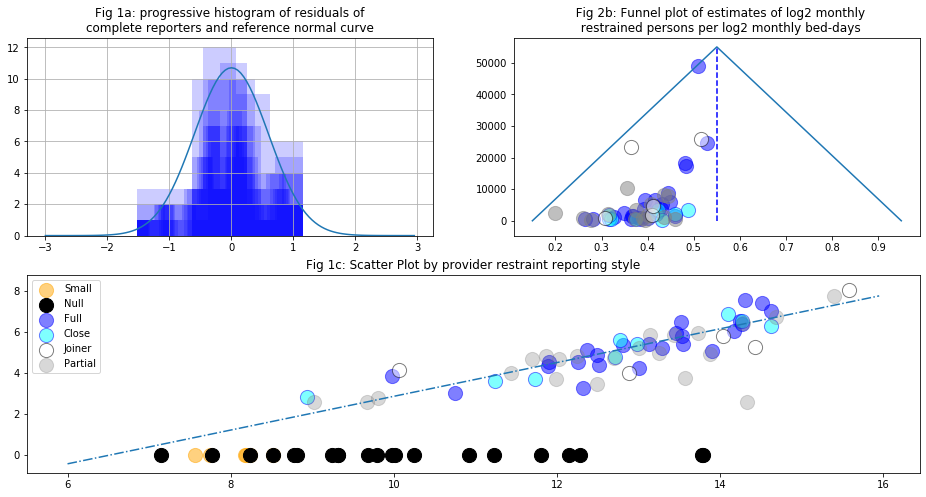


We may there fore attempt to replicate PROD-ALERT "1" and estimate people restrained per 
month in non-complete providers. As in PROD-ALERT "1", there is a clear and 
believable trend, now supported by some new joiners. In the absence of more 
plausible reports we use the trend to predict restraint in NULL reporters.
Predicted people restrained per month in incomplete reporters:
Prediction:	 1305  people per month ( 536 - 3233 ), 95% Conf. Interval.

As in PROD-ALERT's first paper we have used detention as a supportive secondary 
analysis. The distribution of residuals of COMPLETE reporters of detention vs 
restraint appears skewed, not symmetrical. It is skewed such that there is a 
tendency toward lower estimates of log2 restraint per log2 detention.

On the other hand, the funnel plot of estaimtes of persons detained is more 
symmetrical. Our speculative that it is possible to underestimate persons 
detained too, it balacnes out. Note that incomplete reporters can apparently 
high 

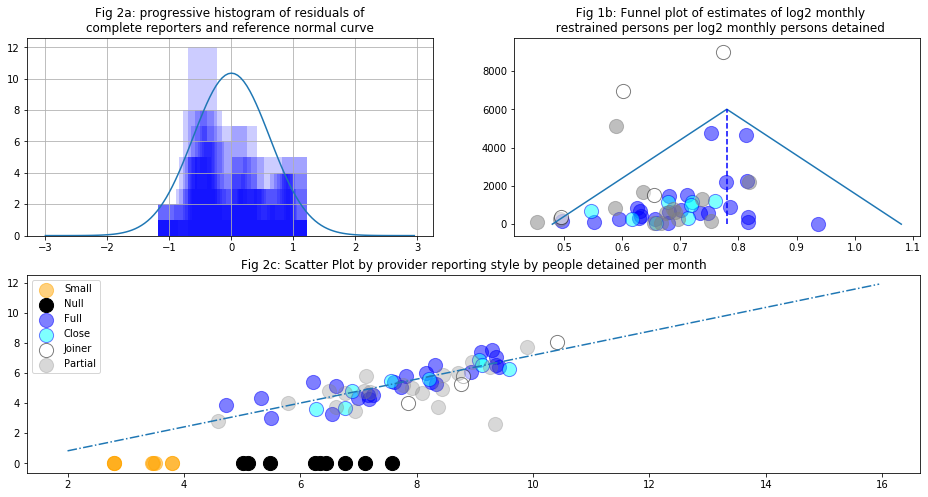


Finally we apply the L-test which is a test for disinformation. As with PROD-
ALERT "1" we do not name providers in this paper. Rather than specify any
provider in the data set we will use the unimpeachable FULL reporters and spoil
thre of their reports. 



KeyError: 'Index'

In [36]:
    
def greet():
    print("""
Welcome to PROD ALERT 2. These results have not been peer reviewed. They are 
shown so that the development can be described as having been done openly, in 
retrospect, later. Underlying figures are already available at NHS Digital.
""")
        
def scatter_classifieds(classified_providers):
    print("""
Figure 1c is the scatter plot for the regression analysis. It correlates size with
restraint. It uses proper averages taken from the whole year of reports for two 
government metrics. Specifically it correlates the log2 of persons restrained per
month with the log2 of bed days per month. Allowing for size, and due to Laplace 
adding one to values, it handles the curvy nature of the relationships and handles
the fact that a report of zero has no logarithm. A provider with plotted size X 
has actual size 2 to the power of X. So a provider at 5.21 on the X axis has a real
size of 2^5.21=37.0.""")
    
    is_small        = [x in("SMALL") for x in classified_providers["Style"]]
    small_rows      = classified_providers[is_small]
    small_beds      = small_rows["LogBeds"]
    small_rstr      = small_rows["LogRstr"]
    plt.scatter(small_beds, small_rstr, color="orange", s=200, alpha=0.5, label="Small")

    is_null        = [x in("NULL") for x in classified_providers["Style"]]
    null_rows      = classified_providers[is_null]
    null_beds      = null_rows["LogBeds"]
    null_rstr      = null_rows["LogRstr"]
    plt.scatter(null_beds, null_rstr, color="black", s=200, alpha=1.0, label="Null")

    is_full        = [x in("FULL") for x in classified_providers["Style"]]
    full_rows      = classified_providers[is_full]
    full_beds      = full_rows["LogBeds"]
    full_rstr      = full_rows["LogRstr"]
    plt.scatter(full_beds, full_rstr, color="blue", s=200, alpha=0.5, label="Full")

    is_close        = [x in("CLOSE") for x in classified_providers["Style"]]
    close_rows      = classified_providers[is_close]
    close_beds      = close_rows["LogBeds"]
    close_rstr      = close_rows["LogRstr"]
    plt.scatter(close_beds, close_rstr, facecolor="cyan", edgecolor="blue", alpha=0.5, s=200, label="Close")

    is_joins        = [x in("JOINS") for x in classified_providers["Style"]]
    joins_rows      = classified_providers[is_joins]
    joins_beds      = joins_rows["LogBeds"]
    joins_rstr      = joins_rows["LogRstr"]
    plt.scatter(joins_beds, joins_rstr, facecolor="white", edgecolor="black", 
                    alpha=0.5, s=200, label="Joiner")

    is_partial      = [x in("PARTIAL") for x in classified_providers["Style"]]
    partial_rows    = classified_providers[is_partial]
    partial_beds    = partial_rows["LogBeds"]
    partial_rstr    = partial_rows["LogRstr"]
    class_scatter   = plt.scatter(partial_beds, partial_rstr, color ="grey", 
                    alpha=0.3, s=200, label="Partial")
                                    
    x                               = np.arange(6,16,0.05)
    best_c, best_m, complete_corr   = count_cm(classified_providers)
    
    plt.plot(x, (best_m*x)+best_c, linestyle = "dashdot")
    plt.title(label = "Fig 1c: Scatter Plot by provider restraint reporting style")
    plt.legend(loc="best")      
    
def tell_unheard(unheard_package):
    incomplete_rep_sum, incomplete_rep_low, incomplete_rep_high = unheard_package
    print("""
We may there fore attempt to replicate PROD-ALERT "1" and estimate people restrained per 
month in non-complete providers. As in PROD-ALERT "1", there is a clear and 
believable trend, now supported by some new joiners. In the absence of more 
plausible reports we use the trend to predict restraint in NULL reporters.""")
          
    print("Predicted people restrained per month in incomplete reporters:")
    print("Prediction:\t", int(incomplete_rep_sum), " people per month (", int(incomplete_rep_low),"-", int(incomplete_rep_high),"), 95% Conf. Interval.")


#       CONTROL

if __name__=="__main__":
                                                
    greet()
    log_main                                    = build_log_main()
    classified_providers, best_c, complete_corr = analyse_provider_residuals(log_main)
    classified_providers, distro_package        = count_bounds(classified_providers, best_c)
    unheard_package                             = predict_incomplete(classified_providers)
    
    verbose = get_verbose()
    if verbose == "Yes":
        display(classified_providers)
    
    figure_one      = pl.figure()
    gs              = gridspec.GridSpec(2, 2)
    ax              = pl.subplot(gs[0, 0])
    distro          = draw_distro_of_complete_residuals(distro_package, complete_corr)
    ax              = pl.subplot(gs[0, 1])
    funnel          = draw_funnel(classified_providers)
    ax              = pl.subplot(gs[1, :])
    scatter_plot    = scatter_classifieds(classified_providers)
    pl.show(figure_one)
    tell_unheard(unheard_package)
    
    
    sect_classified_providers, sect_c, sect_corr = sect_analyse_provider_residuals(log_main)
    sect_classified_providers, sect_distro_package    = sect_count_bounds(sect_classified_providers, sect_c)
    
    verbose = get_verbose()
    if verbose == "Yes":
        display(classified_providers)
    
    
    figure_two      = pl.figure()
    gs              = gridspec.GridSpec(2, 2)
    ax              = pl.subplot(gs[0, 0])
    distro          = sect_draw_distro_of_complete_residuals(sect_distro_package, sect_corr)
    ax              = pl.subplot(gs[0, 1])
    funnel          = sect_draw_funnel(sect_classified_providers)
    ax              = pl.subplot(gs[1, :])
    scatter_plot    = sect_scatter_classifieds(sect_classified_providers)
    pl.show(figure_two)
    
    l_test(classified_providers)
    



    
    
    

In [24]:
# tests \

def test_build_monthly_providers_beds():
    providers              = get_providers()
    monthly_providers_beds = build_monthly_providers_beds(providers)
    assert type(monthly_providers_beds)    == pd.DataFrame, "type test"
    assert type(monthly_providers_beds["beds01_Sep"]) == pd.Series, "type test"
    assert monthly_providers_beds.at["WEST LONDON NHS TRUST","beds01_Sep"] == "19235", "correct value and type"
    assert monthly_providers_beds.at["WEST LONDON NHS TRUST","beds01_Sep"] != 19235,   "correct value and type"
    assert monthly_providers_beds.at["WEST LONDON NHS TRUST","beds01_Sep"] != "999",   "correct value and type"
    assert len(monthly_providers_beds)     == len(set(providers)), "uniqueness test"
    assert monthly_providers_beds.index[1] == providers[1], "matches providers test"
    print("passed build monthly providers beds")
    
def test_build_monthly_providers_rstr():
    providers              = get_providers()
    monthly_providers_rstr = build_monthly_providers_rstr(providers)
    assert type(monthly_providers_rstr)    == pd.DataFrame, "type test"
    assert type(monthly_providers_rstr["rstr01_Sep"]) == pd.Series, "type test"
    assert monthly_providers_rstr.at["WEST LONDON NHS TRUST","rstr01_Sep"] == "75", "correct value and type"
    assert monthly_providers_rstr.at["WEST LONDON NHS TRUST","rstr01_Sep"] != 75,   "correct value and type"
    assert monthly_providers_rstr.at["WEST LONDON NHS TRUST","rstr01_Sep"] != "999","correct value and type"  
    assert len(monthly_providers_rstr)     == len(set(providers)), "uniqueness test"
    assert monthly_providers_rstr.index[1] == providers[1], "matches providers test"
    print("passed build monthly providers rstr")
    
def test_build_monthly_providers_sect():
    providers              = get_providers()
    monthly_providers_sect = build_monthly_providers_sect(providers)
    assert type(monthly_providers_sect)    == pd.DataFrame, "type test"
    assert type(monthly_providers_sect["sect01_Sep"]) == pd.Series, "type test"
    assert monthly_providers_sect.at["WEST LONDON NHS TRUST","sect01_Sep"] == "565", "correct value and type"
    assert monthly_providers_sect.at["WEST LONDON NHS TRUST","sect01_Sep"] != 565,   "correct value and type"
    assert monthly_providers_sect.at["WEST LONDON NHS TRUST","sect01_Sep"] != "999","correct value and type"  
    assert len(monthly_providers_sect)     == len(set(providers)), "uniqueness test"
    assert monthly_providers_sect.index[1] == providers[1], "matches providers test"
    print("passed build monthly providers sect")
    
def test_get_providers():
    providers = get_providers()
    assert type(providers)    == list, "type test"
    assert type(providers[1]) == str, "type test"
    assert len(providers)  == len(set(providers)), "uniqueness test"
    print("passed get providers")
    
def test_laplace_correction_and_log():
    toy         = {'Number':[4,3,2,1]}
    toy_df      = pd.DataFrame(toy)
    log_main    = laplace_correction_and_log(toy_df)
    assert list(log_main.Number) == [2.321928094887362, 2.0, 1.584962500721156, 1.0]    
    toy         = {'Jam':[4,3,2,1],'Spam':[15,31,63,0]}
    toy_df      = pd.DataFrame(toy)
    log_main    = laplace_correction_and_log(toy_df)
    assert list(log_main.Jam)  == [2.321928094887362, 2.0, 1.584962500721156, 1.0]
    assert list(log_main.Spam) == [4.0, 5.0, 6.0, 0.0]
    print("passed laplace correction and log")

def all_tests():
    test_build_monthly_providers_beds()
    test_build_monthly_providers_rstr()
    test_build_monthly_providers_sect()  
    test_get_providers()
    test_laplace_correction_and_log()
    print("passed all tests")
    
all_tests()    

passed build monthly providers beds
passed build monthly providers rstr
passed build monthly providers sect
passed get providers
passed laplace correction and log
passed all tests


In [25]:
"""
NOTES:

The author can provide sensitivity models, upon reasonable request.
Preferably readers may do their own, and can fork the code here.


     SHEFFIELD CHILDREN'S NHS FOUNDATION TRUST average size 490.833333

beds 450 	510 	490 	480 	445 	450 	530 	525 	480 	510 	515 	505 
sect 10  	10  	10  	10  	10  	10  	10  	5   	10  	10  	10  	5


     EQUILIBRIUM HEALTHCARE                    average size 527.916667
     
beds 600 	650 	630 	650 	650 	500 	470 	450 	465 	435 	435 	400 
sect 20    	20  	20  	20  	20  	15  	15  	15  	15  	15  	15  	10

Due to visual inpection small for detentions is set at effectively 500.

These are small for detentions:

SCHOEN CLINIC YORK
GREAT ORMOND STREET HOSPITAL FOR CHILDREN NHS FOUNDATION TRUST
ALDER HEY CHILDREN'S NHS FOUNDATION TRUST
TURNING POINT
NEWMARKET HOUSE HEALTHCARE LTD
WHITTINGTON HEALTH NHS TRUST
MANCHESTER UNIVERSITY NHS FOUNDATION TRUST
NORTHUMBRIA HEALTHCARE NHS FOUNDATION TRUST
NEWBRIDGE CARE SYSTEMS LTD
BRAMLEY HEALTH
REGIS HEALTHCARE LIMITED
RIVERDALE GRANGE LIMITED



Due to visual inspection small for restraint is set at effectively 1011.

     ISLE OF WIGHT NHS TRUST                    average size 1011.250000
     
beds 990 	995 	1090 	1145 	1185 	920 	1075 	905 	1000 	915 	980 	935
sect 20  	30  	25  	25  	30  	30  	25  	30  	35  	20  	20  	20
rstr 5   	15  	15  	15  	15  	20  	20  	15  	15  	15  	10  	10

These are small for restraints:

SCHOEN CLINIC YORK
GREAT ORMOND STREET HOSPITAL FOR CHILDREN NHS FOUNDATION TRUST
ALDER HEY CHILDREN'S NHS FOUNDATION TRUST
TURNING POINT
NEWMARKET HOUSE HEALTHCARE LTD
WHITTINGTON HEALTH NHS TRUST
MANCHESTER UNIVERSITY NHS FOUNDATION TRUST
NORTHUMBRIA HEALTHCARE NHS FOUNDATION TRUST
NEWBRIDGE CARE SYSTEMS LTD
BRAMLEY HEALTH
REGIS HEALTHCARE LIMITED
RIVERDALE GRANGE LIMITED
SHEFFIELD CHILDREN'S NHS FOUNDATION TRUST
EQUILIBRIUM HEALTHCARE
BIRMINGHAM WOMEN'S AND CHILDREN'S NHS FOUNDATION TRUST
DERBYSHIRE COMMUNITY HEALTH SERVICES NHS FOUNDATION TRUST
ACTIVE PATHWAYS
NEWBRIDGE CARE SYSTEMS
MAKING SPACE
ELLERN MEDE BARNET
CARETECH COMMUNITY SERVICES (NO.2) LIMITED

""";